In [21]:
# Inspired by https://www.tensorflow.org/versions/r0.7/tutorials/word2vec/index.html
import collections
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
# Configuration
batch_size = 20
# Dimension of the embedding vector. Two too small to get
# any meaningful embeddings, but let's make it 2 for simple visualization
embedding_size = 2
num_sampled = 15    # Number of negative examples to sample.

plt.rc('font', family='NanumGothic')

# Sample sentences
sentences = ["檢 압박 특검 돌입 내부 동요 탄핵 현실화 朴 사면초가",
            "靑 압박에도 檢 내 갈 길 간다 초강수",
            "內傷 깊어진 靑 특검 탄핵 대응 흔들 조만간 사표반려",
            "朴대통령 김현웅 최재경 사표 쥐고 장고 검찰총장 압박",
            "박지원 靑 검찰총장 압박 의도라면 또 다른 탄핵사유",
            "우리 장관도 사표 동시 사표 후폭풍속 공직사회 동요",
            "김현웅 최재경은 왜 동시에 옷을 벗겠다고 했나",
            "朴대통령 최재경 사표 반려할 듯 靑 항명 아니다",
            "朴대통령 사정방패 붕괴 檢 수사 깜짝 반전 일어날까",
            "침몰하는 배 구원투수는 정홍원 김진태 등 거론",
            "박근혜 정권 내부 붕괴 조짐",
            "靑 검찰 가교 역할 최재경 양측 충돌 치닫자 한계 느낀듯",
            "방탄 깨진 청와대 특검 탄핵 무방비",
            "靑 성형시술 마취 크림 구매 보도에 상처 마취용",
            "靑 최재경 항명 아니다 사표수리 여부 대통령 판단사항",
            "靑 朴대통령 탄핵 정족수 채웠다 지적에 아직 그 단계 아니다",
            "망연자실 청 검찰 공소장에 항의 사퇴 연쇄 붕괴 막기 급급",
            "문 걸어 잠근 靑 朴의 감정 억울함서 분노로",
            "청와대 또 중립적 특검 기대 야 대통령은 피의자",
            "靑 탄핵 속수무책 관망 자중지란 새누리에 방어 기대"]

# sentences to words and count
words = " ".join(sentences).split()
count = collections.Counter(words).most_common()
print ("Word count", count[:5])

# Build dictionaries
rdic = [i[0] for i in count] #reverse dic, idx -> word
dic = {w: i for i, w in enumerate(rdic)} #dic, word -> id
voc_size = len(dic)

# Make indexed word data
data = [dic[word] for word in words]
print('Sample data', data[:10], [rdic[t] for t in data[:10]])

# Let's make a training data for window size 1 for simplicity
# ([the, brown], quick), ([quick, fox], brown), ([brown, jumped], fox), ...
cbow_pairs = [];
for i in range(1, len(data)-1) :
    cbow_pairs.append([[data[i-1], data[i+1]], data[i]]);
print('Context pairs', cbow_pairs[:10])

# Let's make skip-gram pairs
# (quick, the), (quick, brown), (brown, quick), (brown, fox), ...
skip_gram_pairs = [];
for c in cbow_pairs:
    skip_gram_pairs.append([c[1], c[0][0]])
    skip_gram_pairs.append([c[1], c[0][1]])
print('skip-gram pairs', skip_gram_pairs[:5])

def generate_batch(size):
    assert size < len(skip_gram_pairs)
    x_data=[]
    y_data = []
    r = np.random.choice(range(len(skip_gram_pairs)), size, replace=False)
    for i in r:
        x_data.append(skip_gram_pairs[i][0])  # n dim
        y_data.append([skip_gram_pairs[i][1]])  # n, 1 dim
    return x_data, y_data

# generate_batch test
print ('Batches (x, y)', generate_batch(3))

Word count [('靑', 10), ('탄핵', 5), ('朴대통령', 4), ('특검', 4), ('사표', 4)]
Sample data [8, 7, 3, 74, 14, 12, 1, 66, 80, 88] ['檢', '압박', '특검', '돌입', '내부', '동요', '탄핵', '현실화', '朴', '사면초가']
Context pairs [[[8, 3], 7], [[7, 74], 3], [[3, 14], 74], [[74, 12], 14], [[14, 1], 12], [[12, 66], 1], [[1, 80], 66], [[66, 88], 80], [[80, 0], 88], [[88, 44], 0]]
skip-gram pairs [[7, 8], [7, 3], [3, 7], [3, 74], [74, 3]]
Batches (x, y) ([8, 15, 105], [[6], [0], [71]])


In [23]:
# Input data
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
# need to shape [batch_size, 1] for nn.nce_loss
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
# Ops and variables pinned to the CPU because of missing GPU implementation
with tf.device('/gpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs) # lookup table

# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.random_uniform([voc_size, embedding_size],-1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

# Compute the average NCE loss for the batch.
# This does the magic:
#   tf.nn.nce_loss(weights, biases, inputs, labels, num_sampled, num_classes ...)
# It automatically draws negative samples when we evaluate the loss.
loss = tf.reduce_mean(
  tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels,
                 num_sampled, voc_size))

# Use the adam optimizer
train_op = tf.train.AdamOptimizer(1e-1).minimize(loss)

Loss at  0 27.4339
Loss at  10 30.0276
Loss at  20 20.2793
Loss at  30 9.34021
Loss at  40 15.2571
Loss at  50 12.8016
Loss at  60 12.9321
Loss at  70 9.98142
Loss at  80 4.06319
Loss at  90 3.99099


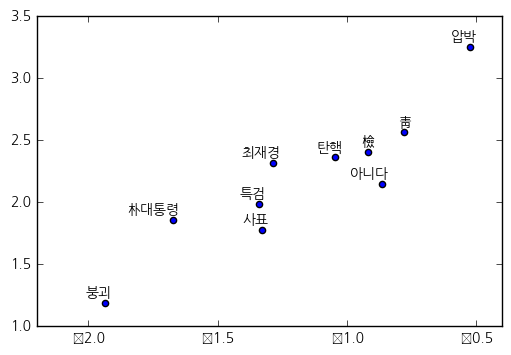

In [24]:
session_conf = tf.ConfigProto()
session_conf.gpu_options.allow_growth = True

# Launch the graph in a session
with tf.Session(config=session_conf) as sess:
    # Initializing all variables
    tf.initialize_all_variables().run()

    for step in range(100):
        batch_inputs, batch_labels = generate_batch(batch_size)
        _, loss_val = sess.run([train_op, loss],
                feed_dict={train_inputs: batch_inputs, train_labels: batch_labels})
        if step % 10 == 0:
          print("Loss at ", step, loss_val) # Report the loss

    # Final embeddings are ready for you to use. Need to normalize for practical use
    trained_embeddings = embeddings.eval()

# Show word2vec if dim is 2
if trained_embeddings.shape[1] == 2:
    labels = rdic[:10] # Show top 10 words
    for i, label in enumerate(labels):
        x, y = trained_embeddings[i,:]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2),
            textcoords='offset points', ha='right', va='bottom')
    plt.savefig("word2vec.png")